# Parallel Knowledge Distillation: Teacher → Two MobileNetV2 Students (Ensemble)
## EXACT MATCH to your reference file models + Parallel Training

## Cell 1: Install Required Libraries

In [1]:
# Install thop for GFLOP calculations
!pip install thop


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: C:\Users\josep\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


## Cell 2: Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2, convnext_tiny
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from thop import profile
import matplotlib.pyplot as plt
import pandas as pd

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA available: False


## Cell 3: GPU Diagnostic

In [3]:
# GPU Diagnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("="*60)
print("DEVICE CONFIGURATION")
print("="*60)
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("✅ GPU is ready!")
else:
    print("⚠️  WARNING: Running on CPU (training will be slower)")
print("="*60)

DEVICE CONFIGURATION
Using device: cpu
⚠️  WARNING: Running on CPU (training will be slower)


## Cell 4: Configuration and Hyperparameters

In [4]:
# Configuration (EXACT FROM YOUR REFERENCE)
data_dir = "plant_dataset"
batch_size = 16
epochs = 5  # Same for both teacher and students
learning_rate = 1e-4
weight_decay = 1e-4

# Knowledge Distillation parameters
alpha = 0.7  # Weight for hard loss
temperature = 4.0  # Temperature for softening

print("Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  KD Alpha: {alpha}")
print(f"  KD Temperature: {temperature}")

Configuration:
  Batch size: 16
  Epochs: 5
  Learning rate: 0.0001
  KD Alpha: 0.7
  KD Temperature: 4.0


## Cell 5: Load Plant Disease Dataset

In [5]:
# Dataset paths (EXACT FROM YOUR REFERENCE)
train_dir = os.path.join(data_dir, "Train", "Train")
val_dir = os.path.join(data_dir, "Validation", "Validation")
test_dir = os.path.join(data_dir, "Test", "Test")

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Get number of classes
num_classes = len(train_dataset.classes)

print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_dataset.classes}")
print(f"\nTrain samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")
print("="*60)

DATASET INFORMATION
Number of classes: 3
Class names: ['Healthy', 'Powdery', 'Rust']

Train samples: 1,322
Validation samples: 60
Test samples: 150

Batch size: 16
Train batches: 83
Val batches: 4
Test batches: 10


## Cell 6: Evaluation Function

In [6]:
def evaluate(model, loader, device):
    """Evaluate model and return metrics"""
    model.eval()
    preds, labels = [], []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            p = torch.argmax(out, dim=1)
            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    return (
        accuracy_score(labels, preds),
        precision_score(labels, preds, average="macro", zero_division=0),
        recall_score(labels, preds, average="macro", zero_division=0),
        f1_score(labels, preds, average="macro", zero_division=0)
    )

## Cell 7: Define Teacher Model (EXACT FROM YOUR REFERENCE)

In [7]:
# ---------- Global Response Normalization (ConvNeXt V2 idea) ----------
# EXACT FROM YOUR REFERENCE FILE
class GRN(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, dim, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, dim, 1, 1))
        self.eps = eps

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(2, 3), keepdim=True)
        nx = gx / (gx.mean(dim=1, keepdim=True) + self.eps)
        return self.gamma * (x * nx) + self.beta + x


# ---------- ConvNeXt V2–Inspired Teacher Model ----------
# EXACT FROM YOUR REFERENCE FILE
class ConvNeXtV2Inspired(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = convnext_tiny(weights="IMAGENET1K_V1")
        in_features = self.backbone.classifier[2].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(in_features),
            nn.Unflatten(1, (in_features, 1, 1)),
            GRN(in_features),
            nn.Flatten(),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


# Create teacher model
teacher = ConvNeXtV2Inspired(num_classes).to(device)
print("="*60)
print("TEACHER MODEL (ConvNeXt V2-Inspired)")
print("="*60)
print(f"Parameters: {sum(p.numel() for p in teacher.parameters()):,}")
print(f"Device: {next(teacher.parameters()).device}")
print("="*60)

TEACHER MODEL (ConvNeXt V2-Inspired)
Parameters: 27,823,971
Device: cpu


## Cell 8: Calculate Teacher GFLOPs

In [8]:
# Calculate Teacher GFLOPs
dummy_input = torch.randn(1, 3, 224, 224).to(device)
macs_teacher, params_teacher = profile(teacher, inputs=(dummy_input,), verbose=False)
flops_teacher = 2 * macs_teacher
gflops_teacher = flops_teacher / 1e9

print("="*60)
print("TEACHER MODEL COMPLEXITY")
print("="*60)
print(f"Parameters: {params_teacher / 1e6:.2f} M")
print(f"FLOPs: {flops_teacher / 1e9:.2f} G")
print(f"GFLOPs: {gflops_teacher:.2f}")
print("="*60)

TEACHER MODEL COMPLEXITY
Parameters: 27.81 M
FLOPs: 8.93 G
GFLOPs: 8.93


## Cell 9: Train Teacher Model

In [9]:
# Teacher training setup (MATCHING YOUR REFERENCE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    teacher.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=epochs
)

print("="*60)
print("TRAINING TEACHER MODEL")
print("="*60)

teacher_history = {'train_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(epochs):
    teacher.train()
    running_loss = 0.0
    
    progress_bar = tqdm(
        train_loader,
        desc=f"Epoch [{epoch+1}/{epochs}]",
        leave=True
    )
    
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = teacher(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    
    acc, prec, rec, f1 = evaluate(teacher, val_loader, device)
    
    teacher_history['train_loss'].append(avg_loss)
    teacher_history['val_acc'].append(acc)
    teacher_history['val_f1'].append(f1)
    
    print(
        f"Epoch {epoch+1} Completed | "
        f"Loss: {avg_loss:.4f} | "
        f"Val Acc: {acc:.4f} | "
        f"Prec: {prec:.4f} | "
        f"Rec: {rec:.4f} | "
        f"F1: {f1:.4f}"
    )

print("\n✅ Teacher training completed!")

TRAINING TEACHER MODEL


Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [1/5]: 100%|██████████| 83/83 [03:09<00:00,  2.28s/it, loss=0.297]


Epoch 1 Completed | Loss: 0.3742 | Val Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000


Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [2/5]: 100%|██████████| 83/83 [02:45<00:00,  2.00s/it, loss=0.293]


Epoch 2 Completed | Loss: 0.2998 | Val Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000


Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [3/5]: 100%|██████████| 83/83 [02:49<00:00,  2.04s/it, loss=0.292]


Epoch 3 Completed | Loss: 0.2972 | Val Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000


Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [4/5]: 100%|██████████| 83/83 [02:45<00:00,  1.99s/it, loss=0.294]


Epoch 4 Completed | Loss: 0.2955 | Val Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000


Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [5/5]: 100%|██████████| 83/83 [02:48<00:00,  2.03s/it, loss=0.292]


Epoch 5 Completed | Loss: 0.2935 | Val Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000

✅ Teacher training completed!


## Cell 10: Evaluate Teacher on Test Set

In [10]:
# Freeze teacher
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

# Evaluate teacher
acc_teacher, prec_teacher, rec_teacher, f1_teacher = evaluate(teacher, test_loader, device)

print("="*60)
print("TEACHER MODEL TEST RESULTS")
print("="*60)
print(f"Accuracy:  {acc_teacher:.4f}")
print(f"Precision: {prec_teacher:.4f}")
print(f"Recall:    {rec_teacher:.4f}")
print(f"F1-score:  {f1_teacher:.4f}")
print("="*60)

c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TEACHER MODEL TEST RESULTS
Accuracy:  0.9800
Precision: 0.9811
Recall:    0.9800
F1-score:  0.9800


## Cell 11: Define Knowledge Distillation Loss

In [11]:
# EXACT FROM YOUR REFERENCE FILE
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.7, temperature=4.0):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        hard_loss = self.ce(student_logits, labels)

        soft_student = F.log_softmax(student_logits / self.temperature, dim=1)
        soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)

        kd_loss = F.kl_div(
            soft_student,
            soft_teacher,
            reduction="batchmean"
        ) * (self.temperature ** 2)

        return self.alpha * hard_loss + (1 - self.alpha) * kd_loss


print("Knowledge Distillation Loss defined")
print(f"  Alpha (hard loss weight): {alpha}")
print(f"  Temperature: {temperature}")

Knowledge Distillation Loss defined
  Alpha (hard loss weight): 0.7
  Temperature: 4.0


## Cell 12: Create Two Student Models (EXACT FROM YOUR REFERENCE)

In [12]:
# Student 1 (EXACT FROM YOUR REFERENCE)
student1 = mobilenet_v2(weights="IMAGENET1K_V1")
student1.classifier[1] = nn.Linear(
    student1.classifier[1].in_features, num_classes
)
student1.to(device)

# Student 2 (EXACT SAME AS STUDENT 1)
student2 = mobilenet_v2(weights="IMAGENET1K_V1")
student2.classifier[1] = nn.Linear(
    student2.classifier[1].in_features, num_classes
)
student2.to(device)

print("="*60)
print("STUDENT MODELS CREATED (MobileNetV2)")
print("="*60)
print(f"Student 1: {sum(p.numel() for p in student1.parameters()):,} parameters")
print(f"Student 1 device: {next(student1.parameters()).device}")
print(f"\nStudent 2: {sum(p.numel() for p in student2.parameters()):,} parameters")
print(f"Student 2 device: {next(student2.parameters()).device}")
print("="*60)

STUDENT MODELS CREATED (MobileNetV2)
Student 1: 2,227,715 parameters
Student 1 device: cpu

Student 2: 2,227,715 parameters
Student 2 device: cpu


## Cell 13: Calculate Students GFLOPs

In [13]:
# Calculate GFLOPs for both students
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Student 1
macs_s1, params_s1 = profile(student1, inputs=(dummy_input,), verbose=False)
flops_s1 = 2 * macs_s1
gflops_s1 = flops_s1 / 1e9

# Student 2
macs_s2, params_s2 = profile(student2, inputs=(dummy_input,), verbose=False)
flops_s2 = 2 * macs_s2
gflops_s2 = flops_s2 / 1e9

print("="*60)
print("STUDENT MODELS COMPLEXITY")
print("="*60)
print(f"Student 1:")
print(f"  Parameters: {params_s1 / 1e6:.2f} M")
print(f"  GFLOPs: {gflops_s1:.2f}")
print(f"\nStudent 2:")
print(f"  Parameters: {params_s2 / 1e6:.2f} M")
print(f"  GFLOPs: {gflops_s2:.2f}")
print(f"\nEnsemble (Combined):")
print(f"  Total GFLOPs: {gflops_s1 + gflops_s2:.2f}")
print(f"\nCompression Ratio:")
print(f"  Teacher: {gflops_teacher:.2f} GFLOPs")
print(f"  Single Student: {gflops_s1:.2f} GFLOPs ({(gflops_s1/gflops_teacher)*100:.1f}%)")
print(f"  Ensemble: {gflops_s1 + gflops_s2:.2f} GFLOPs ({((gflops_s1+gflops_s2)/gflops_teacher)*100:.1f}%)")
print("="*60)

STUDENT MODELS COMPLEXITY
Student 1:
  Parameters: 2.23 M
  GFLOPs: 0.65

Student 2:
  Parameters: 2.23 M
  GFLOPs: 0.65

Ensemble (Combined):
  Total GFLOPs: 1.30

Compression Ratio:
  Teacher: 8.93 GFLOPs
  Single Student: 0.65 GFLOPs (7.3%)
  Ensemble: 1.30 GFLOPs (14.6%)


## Cell 14: Setup Optimizers for Students

In [14]:
# Optimizers for both students (MATCHING YOUR REFERENCE)
optimizer1 = optim.AdamW(student1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer2 = optim.AdamW(student2.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Distillation loss
kd_criterion = DistillationLoss(alpha=alpha, temperature=temperature)

print("Optimizers initialized for both students")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")

Optimizers initialized for both students
Learning rate: 0.0001
Weight decay: 0.0001


## Cell 15: Parallel Training of Both Students

In [15]:
print("="*60)
print("PARALLEL KNOWLEDGE DISTILLATION TRAINING")
print("="*60)

student1_history = {'train_loss': [], 'val_acc': [], 'val_f1': []}
student2_history = {'train_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(epochs):
    student1.train()
    student2.train()
    
    running_loss1 = 0.0
    running_loss2 = 0.0
    
    progress_bar = tqdm(
        train_loader,
        desc=f"KD Epoch [{epoch+1}/{epochs}]",
        leave=True
    )
    
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        
        # Get teacher logits (no gradient)
        with torch.no_grad():
            teacher_logits = teacher(x)
        
        # Train Student 1
        optimizer1.zero_grad()
        student1_logits = student1(x)
        loss1 = kd_criterion(student1_logits, teacher_logits, y)
        loss1.backward()
        optimizer1.step()
        
        running_loss1 += loss1.item()
        
        # Train Student 2
        optimizer2.zero_grad()
        student2_logits = student2(x)
        loss2 = kd_criterion(student2_logits, teacher_logits, y)
        loss2.backward()
        optimizer2.step()
        
        running_loss2 += loss2.item()
        
        progress_bar.set_postfix(
            S1_loss=loss1.item(),
            S2_loss=loss2.item()
        )
    
    # Calculate average losses
    avg_loss1 = running_loss1 / len(train_loader)
    avg_loss2 = running_loss2 / len(train_loader)
    
    # Evaluate both students
    acc1, prec1, rec1, f1_1 = evaluate(student1, val_loader, device)
    acc2, prec2, rec2, f1_2 = evaluate(student2, val_loader, device)
    
    student1_history['train_loss'].append(avg_loss1)
    student1_history['val_acc'].append(acc1)
    student1_history['val_f1'].append(f1_1)
    
    student2_history['train_loss'].append(avg_loss2)
    student2_history['val_acc'].append(acc2)
    student2_history['val_f1'].append(f1_2)
    
    print(
        f"\nEpoch {epoch+1} Completed | "
        f"S1 Loss: {avg_loss1:.4f} | S1 Acc: {acc1:.4f} | S1 F1: {f1_1:.4f}"
    )
    print(
        f"                      | "
        f"S2 Loss: {avg_loss2:.4f} | S2 Acc: {acc2:.4f} | S2 F1: {f1_2:.4f}"
    )

print("\n✅ Parallel distillation training completed!")

PARALLEL KNOWLEDGE DISTILLATION TRAINING


KD Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
KD Epoch [1/5]: 100%|██████████| 83/83 [02:44<00:00,  1.98s/it, S1_loss=0.152, S2_loss=0.119]  
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 1 Completed | S1 Loss: 0.2969 | S1 Acc: 1.0000 | S1 F1: 1.0000
                      | S2 Loss: 0.2902 | S2 Acc: 1.0000 | S2 F1: 1.0000


KD Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
KD Epoch [2/5]: 100%|██████████| 83/83 [03:54<00:00,  2.82s/it, S1_loss=0.148, S2_loss=0.119]  
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 2 Completed | S1 Loss: 0.1280 | S1 Acc: 1.0000 | S1 F1: 1.0000
                      | S2 Loss: 0.1250 | S2 Acc: 1.0000 | S2 F1: 1.0000


KD Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
KD Epoch [3/5]: 100%|██████████| 83/83 [04:52<00:00,  3.53s/it, S1_loss=0.0979, S2_loss=0.0845]
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 3 Completed | S1 Loss: 0.0956 | S1 Acc: 1.0000 | S1 F1: 1.0000
                      | S2 Loss: 0.0990 | S2 Acc: 1.0000 | S2 F1: 1.0000


KD Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
KD Epoch [4/5]: 100%|██████████| 83/83 [04:48<00:00,  3.47s/it, S1_loss=0.0605, S2_loss=0.0533]
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 4 Completed | S1 Loss: 0.1158 | S1 Acc: 1.0000 | S1 F1: 1.0000
                      | S2 Loss: 0.1164 | S2 Acc: 1.0000 | S2 F1: 1.0000


KD Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
KD Epoch [5/5]: 100%|██████████| 83/83 [04:46<00:00,  3.45s/it, S1_loss=0.0908, S2_loss=0.0946]
c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 5 Completed | S1 Loss: 0.0949 | S1 Acc: 1.0000 | S1 F1: 1.0000
                      | S2 Loss: 0.0963 | S2 Acc: 1.0000 | S2 F1: 1.0000

✅ Parallel distillation training completed!


## Cell 16: Ensemble Evaluation Function

In [16]:
def evaluate_ensemble(model1, model2, loader, device):
    """Evaluate ensemble by averaging logits from both models"""
    model1.eval()
    model2.eval()
    
    preds, labels = [], []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            # Get outputs from both models
            out1 = model1(x)
            out2 = model2(x)
            
            # Average the logits (ensemble)
            avg_out = (out1 + out2) / 2.0
            
            p = torch.argmax(avg_out, dim=1)
            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    return (
        accuracy_score(labels, preds),
        precision_score(labels, preds, average="macro", zero_division=0),
        recall_score(labels, preds, average="macro", zero_division=0),
        f1_score(labels, preds, average="macro", zero_division=0)
    )

print("Ensemble evaluation function defined")

Ensemble evaluation function defined


## Cell 17: Evaluate Individual Students on Test Set

In [17]:
# Evaluate Student 1
acc1, prec1, rec1, f1_1 = evaluate(student1, test_loader, device)

print("="*60)
print("STUDENT 1 TEST RESULTS")
print("="*60)
print(f"Accuracy:  {acc1:.4f}")
print(f"Precision: {prec1:.4f}")
print(f"Recall:    {rec1:.4f}")
print(f"F1-score:  {f1_1:.4f}")

# Evaluate Student 2
acc2, prec2, rec2, f1_2 = evaluate(student2, test_loader, device)

print("\n" + "="*60)
print("STUDENT 2 TEST RESULTS")
print("="*60)
print(f"Accuracy:  {acc2:.4f}")
print(f"Precision: {prec2:.4f}")
print(f"Recall:    {rec2:.4f}")
print(f"F1-score:  {f1_2:.4f}")

c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


STUDENT 1 TEST RESULTS
Accuracy:  0.9733
Precision: 0.9742
Recall:    0.9733
F1-score:  0.9733


c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



STUDENT 2 TEST RESULTS
Accuracy:  0.9733
Precision: 0.9742
Recall:    0.9733
F1-score:  0.9733


## Cell 18: Evaluate Ensemble on Test Set

In [18]:
# Evaluate ensemble
acc_ensemble, prec_ensemble, rec_ensemble, f1_ensemble = evaluate_ensemble(
    student1, student2, test_loader, device
)

print("\n" + "="*60)
print("ENSEMBLE (AVERAGED) TEST RESULTS")
print("="*60)
print(f"Accuracy:  {acc_ensemble:.4f}")
print(f"Precision: {prec_ensemble:.4f}")
print(f"Recall:    {rec_ensemble:.4f}")
print(f"F1-score:  {f1_ensemble:.4f}")
print("="*60)

c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



ENSEMBLE (AVERAGED) TEST RESULTS
Accuracy:  0.9733
Precision: 0.9742
Recall:    0.9733
F1-score:  0.9733


## Cell 19: Final Comparison Table

In [19]:
print("\n" + "="*80)
print("FINAL COMPARISON - ALL MODELS")
print("="*80)

results = {
    'Model': ['Teacher', 'Student 1', 'Student 2', 'Ensemble'],
    'GFLOPs': [
        f"{gflops_teacher:.2f}",
        f"{gflops_s1:.2f}",
        f"{gflops_s2:.2f}",
        f"{gflops_s1+gflops_s2:.2f}"
    ],
    'Params (M)': [
        f"{params_teacher/1e6:.2f}",
        f"{params_s1/1e6:.2f}",
        f"{params_s2/1e6:.2f}",
        f"{(params_s1+params_s2)/1e6:.2f}"
    ],
    'Accuracy': [
        f"{acc_teacher:.4f}",
        f"{acc1:.4f}",
        f"{acc2:.4f}",
        f"{acc_ensemble:.4f}"
    ],
    'Precision': [
        f"{prec_teacher:.4f}",
        f"{prec1:.4f}",
        f"{prec2:.4f}",
        f"{prec_ensemble:.4f}"
    ],
    'Recall': [
        f"{rec_teacher:.4f}",
        f"{rec1:.4f}",
        f"{rec2:.4f}",
        f"{rec_ensemble:.4f}"
    ],
    'F1-Score': [
        f"{f1_teacher:.4f}",
        f"{f1_1:.4f}",
        f"{f1_2:.4f}",
        f"{f1_ensemble:.4f}"
    ]
}

df = pd.DataFrame(results)
print(df.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print(f"Ensemble improvement over Student 1: {(acc_ensemble - acc1)*100:+.2f}%")
print(f"Ensemble improvement over Student 2: {(acc_ensemble - acc2)*100:+.2f}%")
print(f"Ensemble vs Teacher accuracy: {(acc_ensemble - acc_teacher)*100:+.2f}%")
print(f"\nCompression: Teacher {gflops_teacher:.2f} GFLOPs → Ensemble {gflops_s1+gflops_s2:.2f} GFLOPs")
print(f"Compression ratio: {((gflops_s1+gflops_s2)/gflops_teacher)*100:.1f}% of teacher complexity")
print("="*80)


FINAL COMPARISON - ALL MODELS
    Model GFLOPs Params (M) Accuracy Precision Recall F1-Score
  Teacher   8.93      27.81   0.9800    0.9811 0.9800   0.9800
Student 1   0.65       2.23   0.9733    0.9742 0.9733   0.9733
Student 2   0.65       2.23   0.9733    0.9742 0.9733   0.9733
 Ensemble   1.30       4.46   0.9733    0.9742 0.9733   0.9733

KEY INSIGHTS:
Ensemble improvement over Student 1: +0.00%
Ensemble improvement over Student 2: +0.00%
Ensemble vs Teacher accuracy: -0.67%

Compression: Teacher 8.93 GFLOPs → Ensemble 1.30 GFLOPs
Compression ratio: 14.6% of teacher complexity


## Cell 20: Visualize Training History

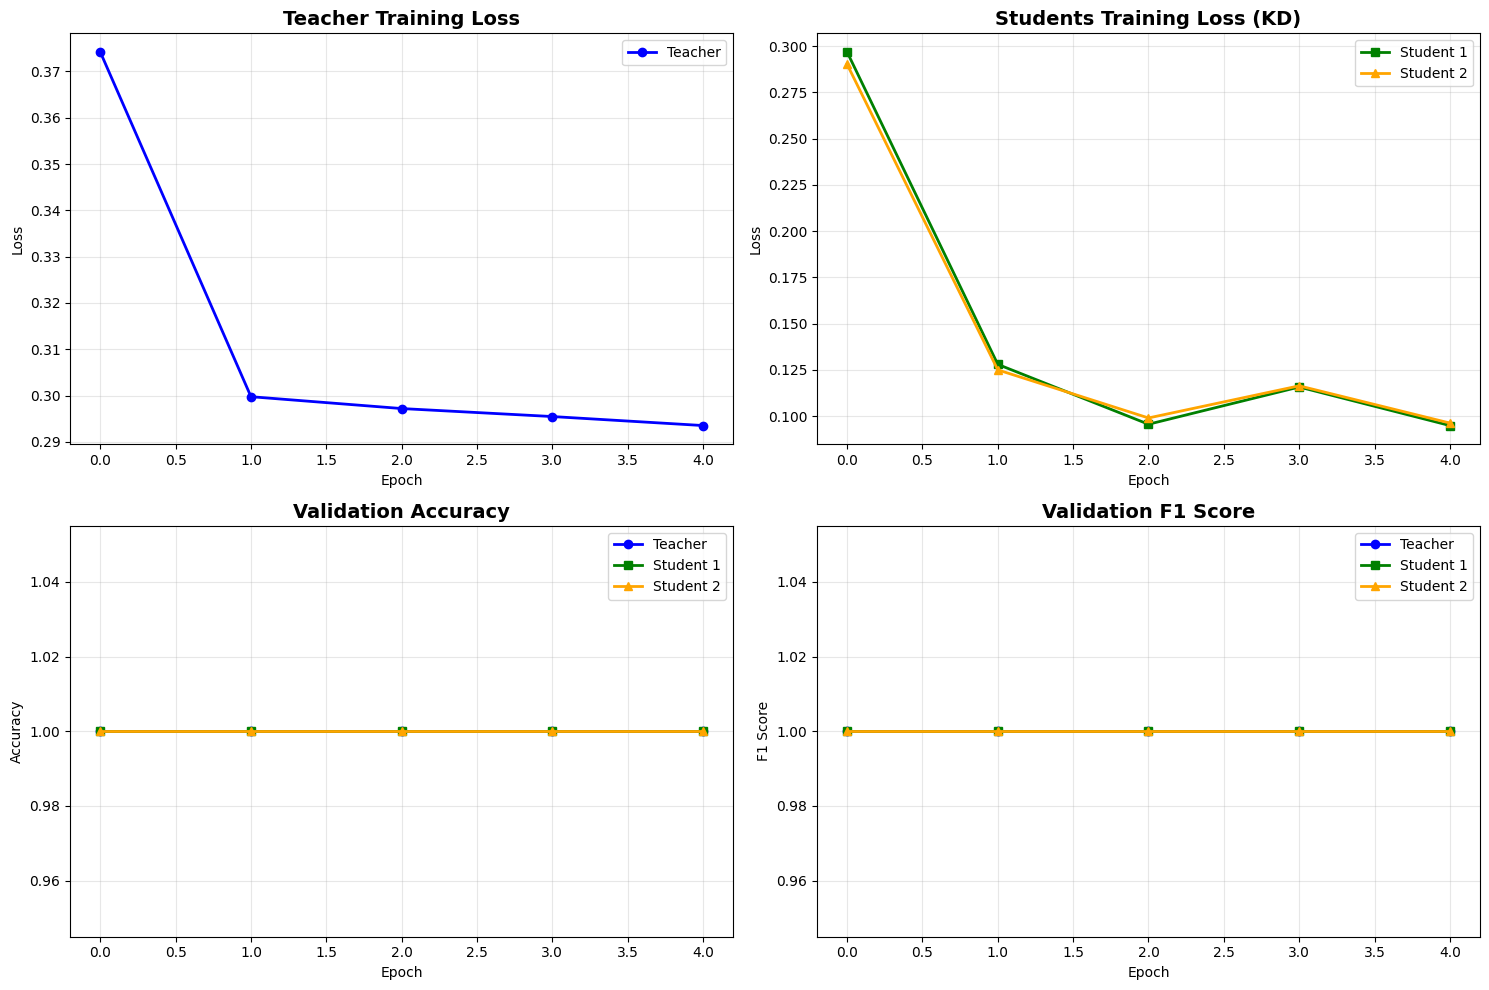

✅ Training history visualization saved as 'training_history.png'


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Teacher Training Loss
axes[0, 0].plot(teacher_history['train_loss'], label='Teacher', color='blue', linewidth=2, marker='o')
axes[0, 0].set_title('Teacher Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Students Training Loss
axes[0, 1].plot(student1_history['train_loss'], label='Student 1', color='green', linewidth=2, marker='s')
axes[0, 1].plot(student2_history['train_loss'], label='Student 2', color='orange', linewidth=2, marker='^')
axes[0, 1].set_title('Students Training Loss (KD)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation Accuracy
axes[1, 0].plot(teacher_history['val_acc'], label='Teacher', color='blue', linewidth=2, marker='o')
axes[1, 0].plot(student1_history['val_acc'], label='Student 1', color='green', linewidth=2, marker='s')
axes[1, 0].plot(student2_history['val_acc'], label='Student 2', color='orange', linewidth=2, marker='^')
axes[1, 0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation F1 Score
axes[1, 1].plot(teacher_history['val_f1'], label='Teacher', color='blue', linewidth=2, marker='o')
axes[1, 1].plot(student1_history['val_f1'], label='Student 1', color='green', linewidth=2, marker='s')
axes[1, 1].plot(student2_history['val_f1'], label='Student 2', color='orange', linewidth=2, marker='^')
axes[1, 1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history visualization saved as 'training_history.png'")

## Cell 21: Save All Models

In [21]:
# Save models
torch.save(teacher.state_dict(), 'teacher_convnext_v2.pth')
torch.save(student1.state_dict(), 'student1_mobilenet_v2.pth')
torch.save(student2.state_dict(), 'student2_mobilenet_v2.pth')

print("="*60)
print("ALL MODELS SAVED")
print("="*60)
print("✅ teacher_convnext_v2.pth")
print("✅ student1_mobilenet_v2.pth")
print("✅ student2_mobilenet_v2.pth")
print("="*60)

ALL MODELS SAVED
✅ teacher_convnext_v2.pth
✅ student1_mobilenet_v2.pth
✅ student2_mobilenet_v2.pth


## Cell 22: Inference Example with Ensemble

In [22]:
def predict_ensemble(model1, model2, image_tensor, device, class_names):
    """Make prediction using ensemble averaging"""
    model1.eval()
    model2.eval()
    
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        
        # Get predictions from both models
        out1 = model1(image_tensor)
        out2 = model2(image_tensor)
        
        # Average outputs
        avg_out = (out1 + out2) / 2.0
        
        # Get probabilities
        probs = F.softmax(avg_out, dim=1)
        
        # Get prediction
        pred_idx = torch.argmax(avg_out, dim=1).item()
        pred_class = class_names[pred_idx]
        confidence = probs[0][pred_idx].item()
        
    return pred_class, confidence, probs.cpu().numpy()[0]

# Example usage
sample_batch = next(iter(test_loader))
sample_image = sample_batch[0][0:1]
sample_label_idx = sample_batch[1][0].item()
sample_label = train_dataset.classes[sample_label_idx]

pred_class, confidence, all_probs = predict_ensemble(
    student1, student2, sample_image, device, train_dataset.classes
)

print("="*60)
print("ENSEMBLE INFERENCE EXAMPLE")
print("="*60)
print(f"True Label: {sample_label}")
print(f"Predicted: {pred_class}")
print(f"Confidence: {confidence:.4f}")
print(f"\nTop 5 Predictions:")
top5_idx = all_probs.argsort()[-5:][::-1]
for idx in top5_idx:
    print(f"  {train_dataset.classes[idx]}: {all_probs[idx]:.4f}")
print("="*60)

c:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ENSEMBLE INFERENCE EXAMPLE
True Label: Healthy
Predicted: Healthy
Confidence: 0.9763

Top 5 Predictions:
  Healthy: 0.9763
  Powdery: 0.0129
  Rust: 0.0107
